# Midterm Optimization Project: Gareth Sun, Zimu Li

In [4]:
from gurobipy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Question 1

In [13]:
#### the objective functions

## Question 2

### (a)

In [14]:
# # test set
# distance_data = pd.read_csv('city_test.csv')
# packages_data = pd.read_csv('package_test.csv')

# importing data, used small datasets
distance_data = pd.read_csv('cities_small.csv')
packages_data = pd.read_csv('packages_small.csv')

In [15]:
distance_data.head()

,id,lat,lon
0,0,37.618806,-122.375417
1,1,36.080044,-115.152235
2,2,33.636700,-84.427864
3,3,39.861667,-104.673167
4,4,33.942496,-118.408049


In [16]:
packages_data.head()

,origin,destination,packages
0,2,15,2878
1,2,6,3745
2,2,3,2973
3,2,5,4868
4,2,8,2796


In [17]:
def distance(lat1, lon1, lat2, lon2):
    dis = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
    return dis

cities = len(distance_data)
distance_matrix_np = np.zeros((cities, cities))

for i in range(cities):
    for j in range(cities):
        distance_matrix_np[i][j] = distance(
            distance_data.iloc[i]['lat'], distance_data.iloc[i]['lon'],
            distance_data.iloc[j]['lat'], distance_data.iloc[j]['lon'])

distance_matrix = pd.DataFrame(distance_matrix_np, 
                                  index=distance_data.index, 
                                  columns=distance_data.index)

print(distance_matrix)

           0          1          2          3          4          5   \
0    0.000000   7.385265  38.155916  17.843769   5.408813  25.773890   
1    7.385265   0.000000  30.821371  11.140536   3.894796  18.392032   
2   38.155916  30.821371   0.000000  21.180710  33.981561  12.631494   
3   17.843769  11.140536  21.180710   0.000000  14.956054  10.334591   
4    5.408813   3.894796  33.981561  14.956054   0.000000  21.395901   
5   25.773890  18.392032  12.631494  10.334591  21.395901   0.000000   
6   41.496117  34.214148   3.819581  24.175123  37.480558  16.254555   
7   48.605534  41.546011  12.743658  30.814161  45.056842  24.468669   
8   39.291477  32.384764   8.642794  21.448988  36.016957  16.553954   
9   42.082015  34.697220   6.069876  26.011176  37.506450  16.350947   
10  34.741702  27.874963   9.037256  16.897934  31.540389  12.875934   
11  10.870017   5.678535  28.463033   7.363158   9.392270  16.896046   
12  28.091269  20.727372  11.508485  13.588259  23.403730   3.37

In [18]:
# Assuming 'packages_data' is a pandas DataFrame with 'origin', 'destination', and 'packages' columns

cities = len(distance_data)
packages_matrix = np.zeros((cities, cities))

# Vectorized approach to populate the matrix, assuming 'origin' and 'destination' are zero-indexed
if 'packages' in packages_data.columns:
    # Convert the 'origin' and 'destination' columns to integer type if they are not already
    packages_data['origin'] = packages_data['origin'].astype(int)
    packages_data['destination'] = packages_data['destination'].astype(int)

    # Use groupby and unstack to create a matrix of package counts
    packages_matrix = packages_data.groupby(['origin', 'destination'])['packages'].sum().unstack(fill_value=0).values
else:
    print("The 'packages' column is missing in the data.")

print(packages_matrix.shape)
print(packages_matrix[1])  # Print the second row of the matrix

(17, 17)
[3584    0 2417 4179 6083 2520  889    0 1056  648 2709 2694 1378 1185
 1411  783 5759]


In [19]:
d = distance_matrix
f = packages_matrix

def hub_spoke_network_model(v):
    
    m = Model("hub_and_spoke")

    # discount factor alpha
    a = 0.75

    # decision variables
    x = m.addVars(cities, cities, vtype = GRB.BINARY, name = "x")  # Spoke-to-Hub and Hub-to-Spoke
    h = m.addVars(cities, cities, vtype = GRB.BINARY, name = "h")  # Hub-to-Hub
    b = m.addVars(cities, vtype = GRB.BINARY, name = "b")  # Hub cities
    e = m.addVars(cities, cities, vtype = GRB.BINARY, name = "e") # Auxiliary variable
    s = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "s") # Auxiliary variable
    y = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "y")  # Auxiliary variable
    z = m.addVars(cities, cities, cities, cities, vtype = GRB.BINARY, name = "z")  # Auxiliary variable
    w = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "w") # Auxiliary variable
    hs = m.addVars(cities, cities, vtype = GRB.BINARY, name = "hs") # Auxiliary variable

    # objective function
    obj = LinExpr()

    # Spoke-to-Hub
    spoke_to_hub = sum(f[i][j] * d[i][j] * e[i,j] for i in range(cities) for j in range(cities))

    # Spoke-to-Hub-to-Hub
    spoke_to_hub_to_hub = sum(f[i][k] * (d[i][j] + a*d[j][k]) * s[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))
    
    # Spoke-to-Hub-to-Spoke
    spoke_to_hub_to_spoke = sum(f[i][k] * (d[i][j] + d[j][k]) * y[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Spoke-to-Hub-to-Hub-to-Spoke
    spoke_to_hub_to_hub_to_spoke = sum(f[i][l] * (d[i][j] + a*d[j][k] + d[k][l]) * z[i,j,k,l] for i in range(cities) for j in range(cities) for k in range(cities) for l in range(cities))

    # Hub-to-Hub
    hub_to_hub = sum(f[i][j] * d[i][j] * a * h[i,j] for i in range(cities) for j in range(cities))

    # Hub-to-Spoke
    hub_to_spoke = sum(f[j][i] * d[j][i] * hs[j,i] for i in range(cities) for j in range(cities))
    
    # Hub-to-Hub_to_Spoke
    hub_to_hub_to_spoke = sum(f[i][k] * (a*d[i][j] + d[j][k]) * w[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Total objective ########
    obj =  spoke_to_hub + spoke_to_hub_to_hub + spoke_to_hub_to_spoke + hub_to_hub + hub_to_spoke + spoke_to_hub_to_hub_to_spoke + hub_to_hub_to_spoke

    m.setObjective(obj, GRB.MINIMIZE)
    
 ### constraints

    # Ensure two-direction Connections
    for i in range(cities):
        for j in range(cities):
            if i != j:
                m.addConstr(x[i,j] == x[j,i])
                m.addConstr(h[i,j] == h[j,i])

    # Constrain on general connection
    for i in range(cities):
        for j in range(cities):
            m.addConstr(x[i,i] == 0)  # Ensure there is no connection between a city and it self
            m.addConstr(x[i,j] <= b[i] + b[j])  # Ensure there will be no connection between spoke and spoke        

    # Constrain on Spoke to Hub          
    for i in range(cities):
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i])) # Ensure every spoke i will connect to only one hub city
        for j in range(cities):
            m.addConstr(e[i,j] <= x[i,j])
            m.addConstr(e[i,j] <= b[j])
            m.addConstr(e[i,j] >= x[i,j] + b[j] - 1)
            m.addConstr(e[i,j] >= 0)
    # Constraint for hub-to-spoke connections
    for i in range(cities):
        for j in range(cities):
            m.addConstr(hs[j,i] <= x[j,i])
            m.addConstr(hs[j,i] <= b[j])
            m.addConstr(hs[j,i] >= x[j,i] + b[j] - 1)
    
                    
    # Spoke-to-Hub-to-Hub Connection Constraints                 
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                # Ensure that if there is a route from spoke i to hub j and then to hub k, city i must be a spoke
                m.addConstr(s[i,j,k] <= x[i,j])
                m.addConstr(s[i,j,k] <= h[j,k])
                m.addConstr(s[i,j,k] <= (1 - b[i]))  # Ensure i is a spoke
                # The following constraint ensures that spoke-to-hub-to-hub routing is valid only if the spoke-to-hub and hub-to-hub connections are true, and i is a spoke
                m.addConstr(s[i,j,k] >= x[i,j] + h[j,k] + (1 - b[i]) - 2)

    # Hub-to-Hub-to-Spoke Connection Constraints
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                m.addConstr(w[i,j,k] <= h[i,j])
                m.addConstr(w[i,j,k] <= x[j,k])
                m.addConstr(w[i,j,k] <= b[i])  # Ensure i is a hub
                m.addConstr(w[i,j,k] <= b[j])  # Ensure j is a hub
                m.addConstr(w[i,j,k] >= h[i,j] + x[j,k] + b[i] + b[j] - 3)
                

    
    
    # Hub constraints
    for i in range(cities):
        m.addConstr(x[i,i] == 0)  # A city cannot connect to itself

        # Ensure each spoke has at least one connection to a hub
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i]))

        for j in range(cities):
            if i != j:
                m.addConstr(h[i,j] <= b[i])
                m.addConstr(h[i,j] <= b[j])
                m.addConstr(h[i,j] >= b[i] + b[j] - 1)
            for k in range(cities):
                m.addConstr(y[i,j,k] <= x[i,j])
                m.addConstr(y[i,j,k] <= x[j,k])
                m.addConstr(y[i,j,k] <= b[j])
                m.addConstr(y[i,j,k] >= x[i,j] + x[j,k] + b[j] - 2)
                for l in range(cities):
                    m.addConstr(z[i,j,k,l] <= x[i,j])
                    m.addConstr(z[i,j,k,l] <= h[j,k])
                    m.addConstr(z[i,j,k,l] <= x[k,l])
                    m.addConstr(z[i,j,k,l] >= x[i,j] + h[j,k] + x[k,l] - 2)

    # set the number of hubs = v
    m.addConstr(sum(b[i] for i in range(cities)) == v)

    m.optimize()
    
    if m.status == GRB.Status.OPTIMAL:
        hub_city_ids = [i for i in range(cities) if b[i].x > 0.5]
        connections = [[i, j] for i in range(cities) for j in range(cities) if x[i,j].x > 0.5 or h[i,j].x > 0.5]

        intermediate_hubs_count = 0

        for i in range(cities):
            for j in range(cities):
                for k in range(cities):
                    if s[i,j,k].x > 0.5:  # if s[i,j,k] = 1, count += 1
                        intermediate_hubs_count += f[i,k]
                    if y[i,j,k].x > 0.5:  # if y[i,j,k] = 1, count += 1
                        intermediate_hubs_count += f[i,k]
                    if w[i,j,k].x > 0.5:  # if w[i,j,k] = 1, count += 1
                        intermediate_hubs_count += f[i,k]
                    for l in range(cities):
                        if z[i,j,k,l].x > 0.5:  # if z[i,j,k,l] =1， count +2
                            intermediate_hubs_count += 2 * f[i,l]
        # total_pacs = sum(f[i][j] for i in range(cities) for j in range(cities))
        m.reset()

        return hub_city_ids, connections, intermediate_hubs_count
    else:
        print("Infeasible")
        m.computeIIS()
        m.write("model.ilp")
        return None, None, None


In [20]:
hub_city_ids2, connections2, intermediate_hubs_count2 = hub_spoke_network_model(2)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x20cc94ba
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...

Interrupt request received
Presolve removed 358643 rows and 56927 columns
Presolve time: 9.22s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.620616e+07
Found heuristic solution: objective 2.347769e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Pr

In [21]:
print(connections2)

[[0, 16], [1, 16], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [3, 16], [4, 16], [5, 2], [6, 2], [7, 2], [8, 2], [9, 2], [10, 2], [11, 16], [12, 2], [13, 2], [14, 2], [15, 2], [16, 0], [16, 1], [16, 2], [16, 3], [16, 4], [16, 11]]


In [22]:
print(hub_city_ids2)

[2, 16]


In [23]:
print(intermediate_hubs_count2)

597250


### (b)

In [24]:
def plot_hub_spoke(hub_city_ids, connections):
    plt.figure(figsize=(10, 6))

    plt.scatter(distance_data['lon'], distance_data['lat'], label='Spoke', zorder=1)

    for i in hub_city_ids:
        hub_row = distance_data[distance_data['id'] == i].iloc[0]
        plt.scatter(hub_row['lon'], hub_row['lat'], c='lightgreen', marker='p', s=200, label='Hub' if 'Hub' not in plt.gca().get_legend_handles_labels()[1] else "", zorder=2)

    for i, row in distance_data.iterrows():
        plt.text(row['lon'], row['lat'], str(row['id']), fontsize=9, zorder=3)

    for connection in connections:
        spoke, hub = connection
        spoke_row = distance_data[distance_data['id'] == spoke].iloc[0]
        hub_row = distance_data[distance_data['id'] == hub].iloc[0]
        if spoke in hub_city_ids and hub in hub_city_ids:
            color = 'blue'
        else:
            color = 'red'
        plt.annotate('', xy=(hub_row['lon'], hub_row['lat']), xytext=(spoke_row['lon'], spoke_row['lat']),
                     arrowprops=dict(arrowstyle="<->", color=color, lw=1.5))

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()



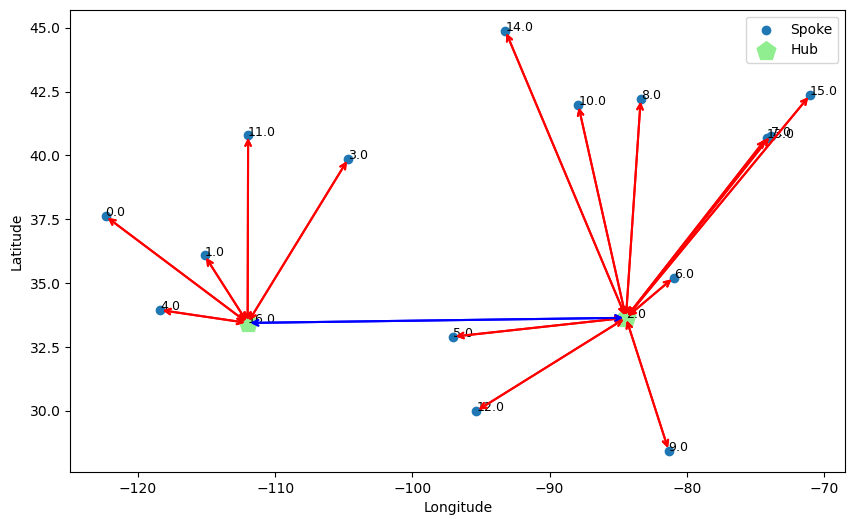

In [25]:
plot_hub_spoke(hub_city_ids2, connections2)

### (c)

#### 1 hub

In [26]:
hub_city_ids1, connections1, intermediate_hubs_count1 = hub_spoke_network_model(1)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x1a659701
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 401966 rows and 99433 columns
Presolve time: 7.69s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 7.75 seconds (7.41 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1.83276e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.832756910952e+07, best bound 1.832756910952e+07, gap 0.0000%
Discarded solution information


In [27]:
print(connections1)
print(hub_city_ids1)
print(intermediate_hubs_count1)

[[0, 5], [1, 5], [2, 5], [3, 5], [4, 5], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [5, 12], [5, 13], [5, 14], [5, 15], [5, 16], [6, 5], [7, 5], [8, 5], [9, 5], [10, 5], [11, 5], [12, 5], [13, 5], [14, 5], [15, 5], [16, 5]]
[5]
505540


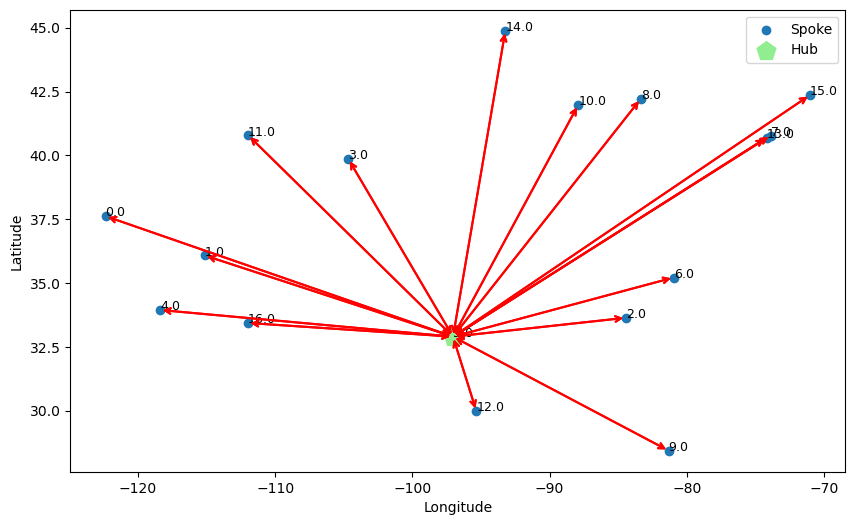

In [28]:
plot_hub_spoke(hub_city_ids1, connections1)

In [29]:
# def total_distance_traveled(connections):

#     total_distance = 0

#     for connection in connections:
#         i, j = connection
#         distance_ij = d[i][j]  
#         packages_ij = f[i][j] 

#         total_distance += distance_ij * packages_ij

#     return(total_distance)

In [30]:
# total_distance_traveled1 = total_distance_traveled(connections1)
# print('Total distance traveled when there is 1 hub:', total_distance_traveled1)

Total distance traveled when there is 1 hub: 1301773.1626438175


#### 4 hubs

In [31]:
hub_city_ids4, connections4, intermediate_hubs_count4 = hub_spoke_network_model(4)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x7e2525d7
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 7.58s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.555494e+07
Found heuristic solution: objective 2.264557e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

In [32]:
# total_distance_traveled4 = total_distance_traveled(connections4)
# print('Total distance traveled when there are 4 hubs:', total_distance_traveled4)

Total distance traveled when there are 4 hubs: 1098488.155470701


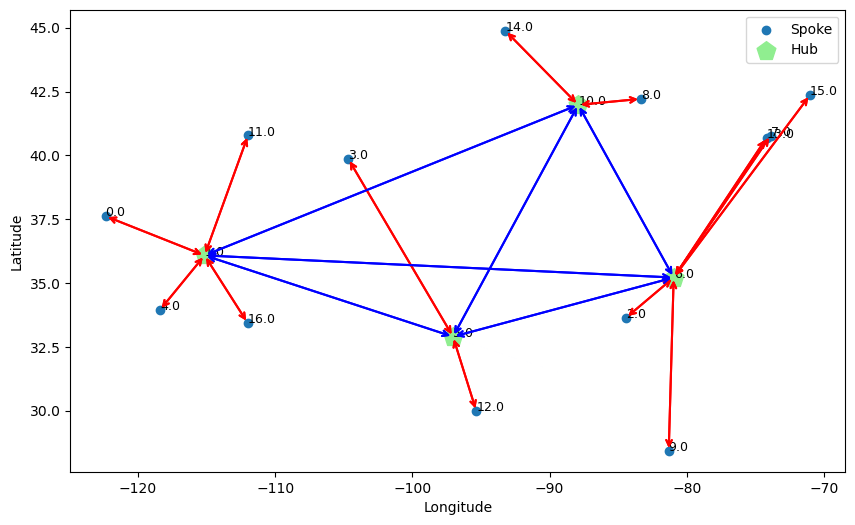

[1, 5, 6, 10]


In [61]:
plot_hub_spoke(hub_city_ids4, connections4)
print(hub_city_ids4)

#### 6 hubs

In [34]:
hub_city_ids6, connections6, intermediate_hubs_count6 = hub_spoke_network_model(6)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x7d69ff5c
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 6.92s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.450928e+07
Found heuristic solution: objective 2.199534e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

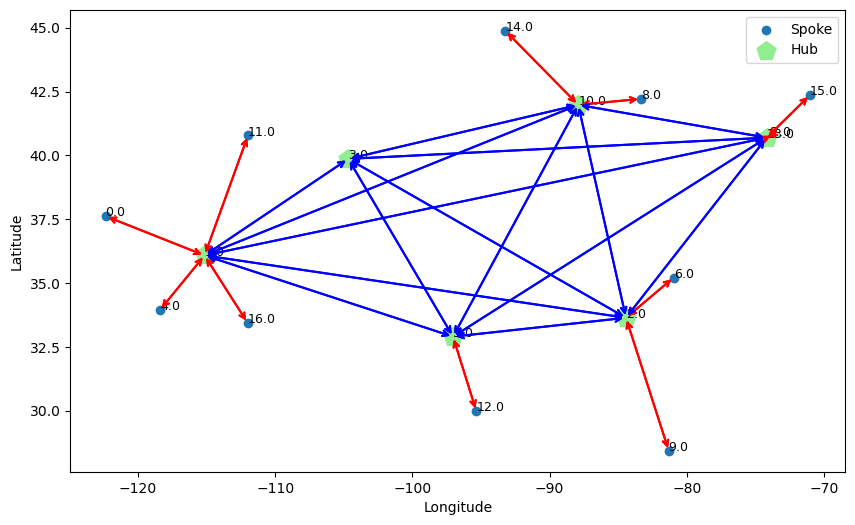

[1, 2, 3, 5, 10, 13]


In [62]:
plot_hub_spoke(hub_city_ids6, connections6)
print(hub_city_ids6)

In [36]:
# total_distance_traveled6 = total_distance_traveled(connections6)
# print('Total distance traveled when there are 6 hubs:', total_distance_traveled6)

Total distance traveled when there are 6 hubs: 1941918.378660402


In [2]:
total_distance_traveled1 = 1.832756910952e+07
total_distance_traveled2 = 1.353134014818e+07
total_distance_traveled4 = 1.090405449706e+07
total_distance_traveled6 = 8.964540322393e+06


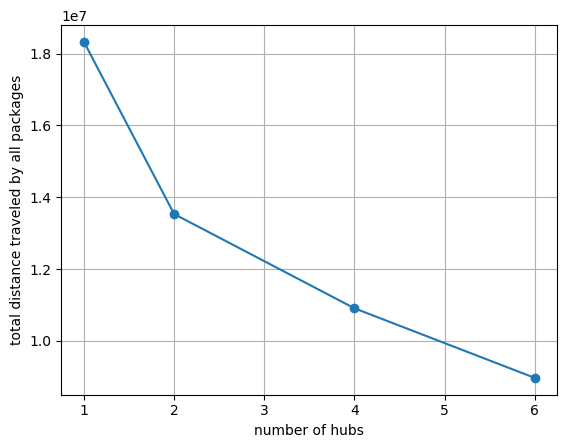

In [5]:
distances = [total_distance_traveled1,  total_distance_traveled2, 
             total_distance_traveled4, total_distance_traveled6]

num_of_hubs = [1, 2, 4, 6]

plt.plot(num_of_hubs, distances, marker='o')
plt.xlabel('number of hubs')
plt.ylabel('total distance traveled by all packages')
plt.grid(True)
plt.show()

In [63]:
print(distances)

[1301773.1626438175, 1236255.9238509636, 1098488.155470701, 1941918.378660402]


## Question 3

### (a)

In [47]:
from collections import defaultdict

total_packages = packages_data.iloc[:, 2].sum()

def overhead_cost_average(c, intermediate_hubs_count):

    # Calculate the total overhead cost
    total_cost = intermediate_hubs_count * c

    # If there are no packages, avoid division by zero by returning 0
    if total_packages == 0:
        return 0

    # Calculate the average overhead cost per package
    average_cost = total_cost / total_packages

    return average_cost, total_cost

# print (total_packages)

In [57]:
c = 100

# when number of hubs == 1
average_cost1, total_cost1 = overhead_cost_average(c, intermediate_hubs_count1)
print('Operational overhead cost per package when there is 1 hub:', average_cost1)

# when number of hubs == 2
average_cost2, total_cost2 = overhead_cost_average(c, intermediate_hubs_count2)
print('Operational overhead cost per package when there are 2 hubs:', average_cost2)

# when number of hubs == 4
average_cost4, total_cost4 = overhead_cost_average(c, intermediate_hubs_count4)
print('Operational overhead cost per package when there are 4 hubs:', average_cost4)

# when number of hubs == 6
average_cost6, total_cost6 = overhead_cost_average(c,  intermediate_hubs_count6)
print('Operational overhead cost per package when there are 6 hubs:', average_cost6)

Operational overhead cost per package when there is 1 hub: 86.16302356299799
Operational overhead cost per package when there are 2 hubs: 101.79385572457284
Operational overhead cost per package when there are 4 hubs: 110.34266479185308
Operational overhead cost per package when there are 6 hubs: 88.16532447057821


### (b)

In [58]:
total_cost2

59725000

In [55]:
total_operational_overhead_cost = [total_cost1, total_cost2, total_cost4, total_cost6]

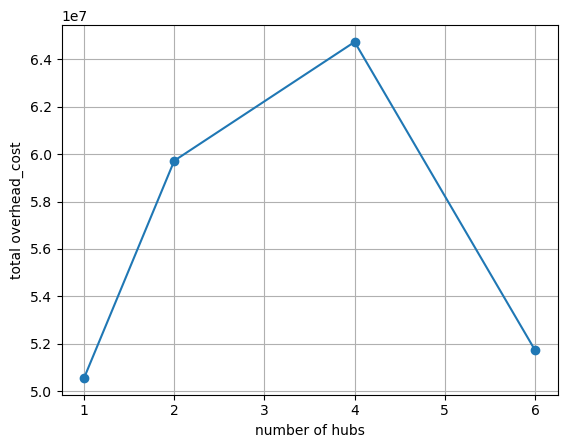

In [64]:
plt.plot(num_of_hubs, total_operational_overhead_cost, marker='o')
plt.xlabel('number of hubs')
plt.ylabel('total overhead_cost')
plt.grid(True)
plt.show()

We can see that when there are 2 hubs, the average overhead_cost is the lowest, which may inform FreshFarm's decision of setting 2 hubs to avoid extra overhead cost

## Question 4

### (a)

In [59]:
d = distance_matrix
f = packages_matrix

def hub_spoke_network_model_cost(v, c):
    
    m = Model("hub_and_spoke")

    # discount factor alpha
    a = 0.75

    # decision variables
    x = m.addVars(cities, cities, vtype = GRB.BINARY, name = "x")  # Spoke-to-Hub and Hub-to-Spoke
    h = m.addVars(cities, cities, vtype = GRB.BINARY, name = "h")  # Hub-to-Hub
    b = m.addVars(cities, vtype = GRB.BINARY, name = "b")  # Hub cities
    e = m.addVars(cities, cities, vtype = GRB.BINARY, name = "e") # Auxiliary variable
    s = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "s") # Auxiliary variable
    y = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "y")  # Auxiliary variable
    z = m.addVars(cities, cities, cities, cities, vtype = GRB.BINARY, name = "z")  # Auxiliary variable
    w = m.addVars(cities, cities, cities, vtype = GRB.BINARY, name = "w") # Auxiliary variable
    hs = m.addVars(cities, cities, vtype = GRB.BINARY, name = "hs") # Auxiliary variable

    # objective function
    obj = LinExpr()

    # Spoke-to-Hub
    spoke_to_hub = sum(f[i][j] * d[i][j] * e[i,j] for i in range(cities) for j in range(cities))

    # Spoke-to-Hub-to-Hub
    spoke_to_hub_to_hub = sum(f[i][k] * (d[i][j] + a*d[j][k] + c) * s[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))
    
    # Spoke-to-Hub-to-Spoke
    spoke_to_hub_to_spoke = sum(f[i][k] * (d[i][j] + d[j][k] + c) * y[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Spoke-to-Hub-to-Hub-to-Spoke
    spoke_to_hub_to_hub_to_spoke = sum(f[i][l] * (d[i][j] + a*d[j][k] + d[k][l] + 2*c) * z[i,j,k,l] for i in range(cities) for j in range(cities) for k in range(cities) for l in range(cities))

    # Hub-to-Hub
    hub_to_hub = sum(f[i][j] * d[i][j] * a * h[i,j] for i in range(cities) for j in range(cities))

    # Hub-to-Spoke
    hub_to_spoke = sum(f[j][i] * d[j][i] * hs[j,i] for i in range(cities) for j in range(cities))
    
    # Hub-to-Hub_to_Spoke
    hub_to_hub_to_spoke = sum(f[i][k] * (a*d[i][j] + d[j][k] +c ) * w[i,j,k] for i in range(cities) for j in range(cities) for k in range(cities))

    # Total objective ########
    obj =  spoke_to_hub + spoke_to_hub_to_hub + spoke_to_hub_to_spoke + hub_to_hub + hub_to_spoke + spoke_to_hub_to_hub_to_spoke + hub_to_hub_to_spoke

    m.setObjective(obj, GRB.MINIMIZE)
    
 ### constraints

    # Ensure two-direction Connections
    for i in range(cities):
        for j in range(cities):
            if i != j:
                m.addConstr(x[i,j] == x[j,i])
                m.addConstr(h[i,j] == h[j,i])

    # Constrain on general connection
    for i in range(cities):
        for j in range(cities):
            m.addConstr(x[i,i] == 0)  # Ensure there is no connection between a city and it self
            m.addConstr(x[i,j] <= b[i] + b[j])  # Ensure there will be no connection between spoke and spoke        

    # Constrain on Spoke to Hub          
    for i in range(cities):
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i])) # Ensure every spoke i will connect to only one hub city
        for j in range(cities):
            m.addConstr(e[i,j] <= x[i,j])
            m.addConstr(e[i,j] <= b[j])
            m.addConstr(e[i,j] >= x[i,j] + b[j] - 1)
            m.addConstr(e[i,j] >= 0)
    # Constraint for hub-to-spoke connections
    for i in range(cities):
        for j in range(cities):
            m.addConstr(hs[j,i] <= x[j,i])
            m.addConstr(hs[j,i] <= b[j])
            m.addConstr(hs[j,i] >= x[j,i] + b[j] - 1)
    
                    
    # Spoke-to-Hub-to-Hub Connection Constraints                 
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                # Ensure that if there is a route from spoke i to hub j and then to hub k, city i must be a spoke
                m.addConstr(s[i,j,k] <= x[i,j])
                m.addConstr(s[i,j,k] <= h[j,k])
                m.addConstr(s[i,j,k] <= (1 - b[i]))  # Ensure i is a spoke
                # The following constraint ensures that spoke-to-hub-to-hub routing is valid only if the spoke-to-hub and hub-to-hub connections are true, and i is a spoke
                m.addConstr(s[i,j,k] >= x[i,j] + h[j,k] + (1 - b[i]) - 2)

    # Hub-to-Hub-to-Spoke Connection Constraints
    for i in range(cities):
        for j in range(cities):
            for k in range(cities):
                m.addConstr(w[i,j,k] <= h[i,j])
                m.addConstr(w[i,j,k] <= x[j,k])
                m.addConstr(w[i,j,k] <= b[i])  # Ensure i is a hub
                m.addConstr(w[i,j,k] <= b[j])  # Ensure j is a hub
                m.addConstr(w[i,j,k] >= h[i,j] + x[j,k] + b[i] + b[j] - 3)
                

    
    
    # Hub constraints
    for i in range(cities):
        m.addConstr(x[i,i] == 0)  # A city cannot connect to itself

        # Ensure each spoke has at least one connection to a hub
        m.addConstr(sum(e[i,j] for j in range(cities)) >= (1 - b[i]))

        for j in range(cities):
            if i != j:
                m.addConstr(h[i,j] <= b[i])
                m.addConstr(h[i,j] <= b[j])
                m.addConstr(h[i,j] >= b[i] + b[j] - 1)
            for k in range(cities):
                m.addConstr(y[i,j,k] <= x[i,j])
                m.addConstr(y[i,j,k] <= x[j,k])
                m.addConstr(y[i,j,k] <= b[j])
                m.addConstr(y[i,j,k] >= x[i,j] + x[j,k] + b[j] - 2)
                for l in range(cities):
                    m.addConstr(z[i,j,k,l] <= x[i,j])
                    m.addConstr(z[i,j,k,l] <= h[j,k])
                    m.addConstr(z[i,j,k,l] <= x[k,l])
                    m.addConstr(z[i,j,k,l] >= x[i,j] + h[j,k] + x[k,l] - 2)

    # set the number of hubs = v
    m.addConstr(sum(b[i] for i in range(cities)) == v)

    m.optimize()
    
    # check feasibility
    if m.status != GRB.Status.OPTIMAL:
        print("Infeasible")
        m.computeIIS()
        return None, None
    
    else: 
        # extract hub city id
        hub_city_ids = [i for i in range(cities) if b[i].x == 1]

        # extract connections
        connections = [[i, j] for i in range(cities) for j in range(cities) if (x[i,j].x == 1 or h[i,j].x == 1)]

    # reset the model
    m.reset()

    return hub_city_ids, connections

(b)

In [ ]:
hub_city_ids_cost5, connections_cost5 = hub_spoke_network_model_cost(2, 5)
total_distance_traveled_cost5 = total_distance_traveled(connections_cost5)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xae43b1e6
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 89196 rows and 19689 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 5.85s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.882499e+07
Found heuristic solution: objective 2.602929e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...



total distance traveled with cost 5: 1236255.9238509636



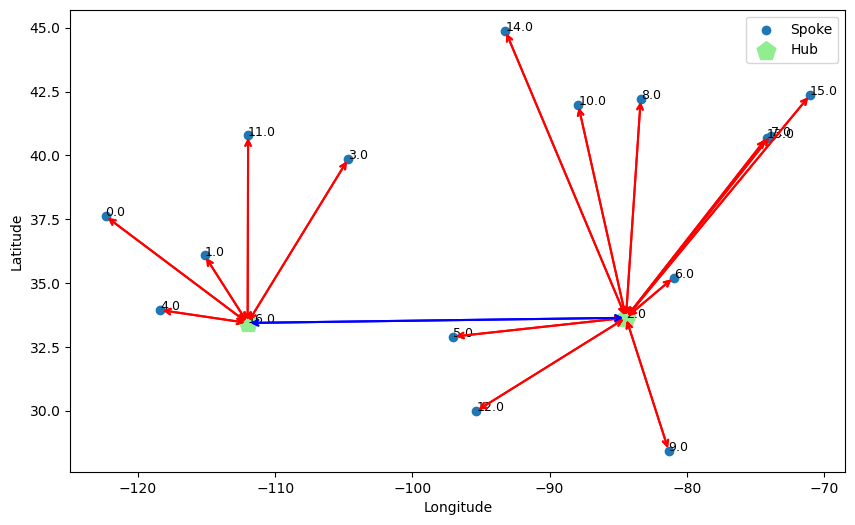

In [ ]:
print()
print(f"total distance traveled with cost 5: {total_distance_traveled_cost5}")
print()
plot_hub_spoke(hub_city_ids_cost5, connections_cost5)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xdf7ae133
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 9.62s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 2.882499e+07
Found heuristic solution: objective 2.602929e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

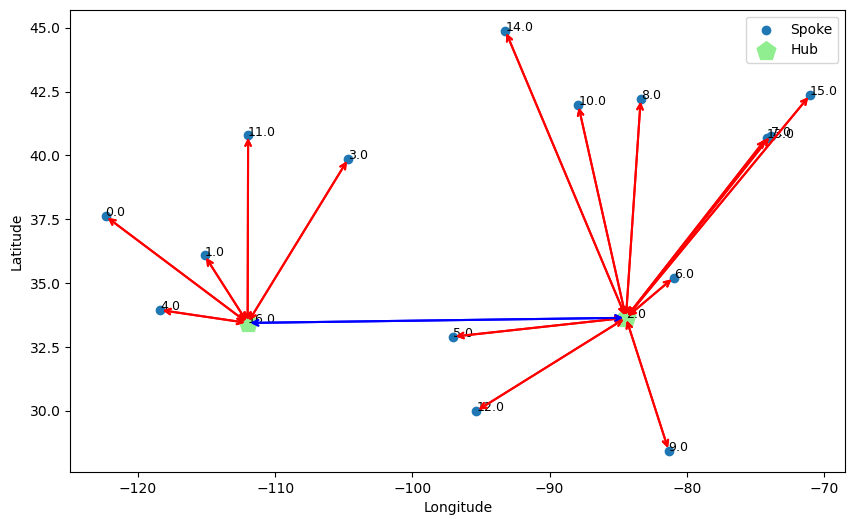

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x3a663dfd
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 9e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 9.08s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 3.144383e+07
Found heuristic solution: objective 2.858090e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

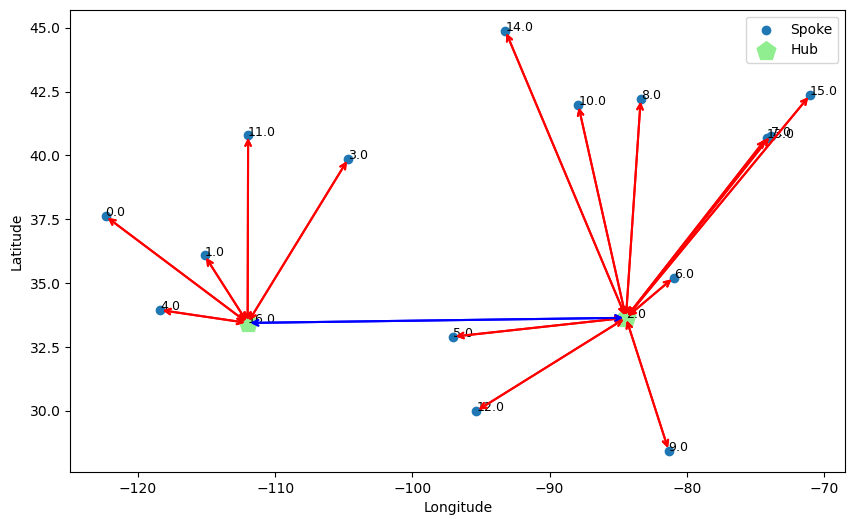

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0x33d025d0
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 7.50s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 3.668150e+07
Found heuristic solution: objective 3.368411e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

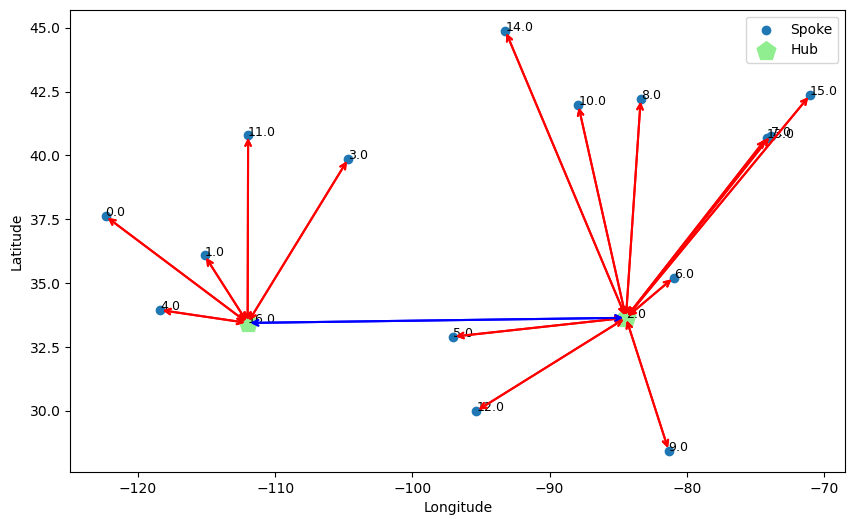

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401966 rows, 99433 columns and 1005856 nonzeros
Model fingerprint: 0xb17aedab
Variable types: 0 continuous, 99433 integer (99433 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 54876 rows and 10999 columns (presolve time = 5s) ...
Presolve removed 358643 rows and 56927 columns
Presolve time: 7.50s
Presolved: 43323 rows, 42506 columns, 167010 nonzeros
Variable types: 0 continuous, 42506 integer (42506 binary)
Found heuristic solution: objective 4.715684e+07
Found heuristic solution: objective 4.389053e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      

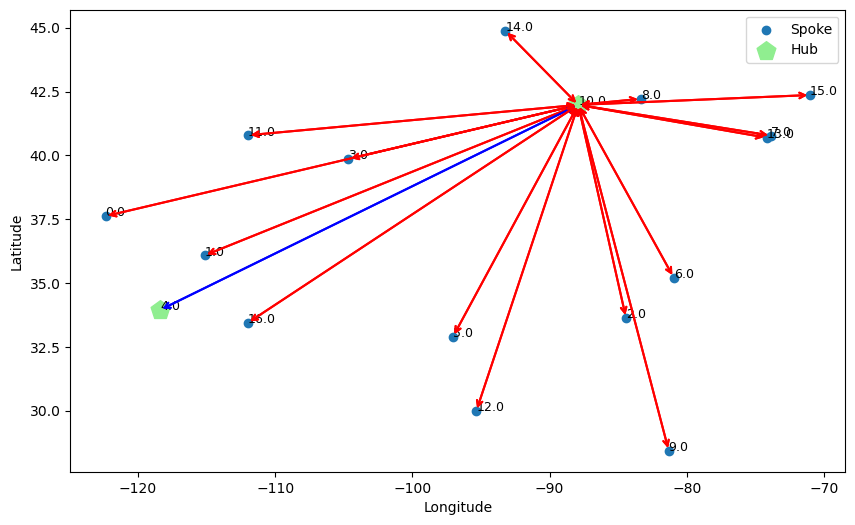

In [60]:
costs = [5,10,20,40]

for cost in costs:
    hub_city_ids, connections = hub_spoke_network_model_cost(2, cost)
    total_distance = total_distance_traveled(connections)
    print(f"\nTotal distance traveled with cost {cost}: {total_distance}\n")
    plot_hub_spoke(hub_city_ids, connections)

In [ ]:
costs = 50

hub_city_ids, connections = hub_spoke_network_model_cost(2, cost)
total_distance = total_distance_traveled(connections)
print(f"\nTotal distance traveled with cost {cost}: {total_distance}\n")
plot_hub_spoke(hub_city_ids, connections)